In [1]:
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import xroms
import numpy as np
import seawater as sw
import sys
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

import seaborn as sns
import matplotlib.colors as mcolors

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
import warnings

warnings.filterwarnings("ignore")

# Reading CROCO files

In [4]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [5]:
# timer_wrf=pd.DatetimeIndex(varfw.time_counter)
# timer_croco_h=pd.DatetimeIndex(varf.time_counter)
# timer_croco_d=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())

# tim_str=['Jan','Feb','Mar','Apr','May','Jun','Jul']

In [6]:
gc.collect()

0

In [7]:
# chunks_new={'dayofyear':40}
chunks_new={'time_counter':10}


dx=500

In [8]:
%%time
# uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=varf.u
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

# ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=vart.u
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();

# vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=varf.v
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

# vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vart.v
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



CPU times: user 15.3 s, sys: 33.6 s, total: 48.9 s
Wall time: 3min 8s


In [9]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [10]:
zeta_f=np.gradient(vf,axis=2)/dx -np.gradient(uf,axis=1)/dx
zeta_t=np.gradient(vt,axis=2)/dx -np.gradient(ut,axis=1)/dx

In [11]:
div_f=np.gradient(uf,axis=2)/dx +np.gradient(vf,axis=1)/dx
div_t=np.gradient(ut,axis=2)/dx +np.gradient(vt,axis=1)/dx

In [12]:

# tf=varf.temp.groupby("time_counter.dayofyear").mean()
rhof=varf.rho
rhof=rhof.chunk(chunks=chunks_new);
rhof=rhof[:,120:-120,120:800].compute();

# tt=vart.temp.groupby("time_counter.dayofyear").mean()
rhot=vart.rho
rhot=rhot.chunk(chunks=chunks_new);
rhot=rhot[:,120:-120,120:800].compute();



In [13]:
f=sw.f(rhot.nav_lat_rho[1:-1,:])

In [14]:
import xroms
bf=xroms.buoyancy(rhof)#[:,1:-1,:]
bt=xroms.buoyancy(rhot)#[:,1:-1,:]

In [15]:
bx_f=(np.gradient(bf[:,1:-1,:],axis=2)/dx)
by_f=(np.gradient(bf[:,1:-1,:],axis=1)/dx)

bx_t=(np.gradient(bt[:,1:-1,:],axis=2)/dx)
by_t=(np.gradient(bt[:,1:-1,:],axis=1)/dx)

In [16]:
bM_f=np.sqrt(bx_f**2+by_f**2)
bM_t=np.sqrt(bx_t**2+by_t**2)

In [17]:
bM_full_norm=(bM_f/((f**2)[None,:,:]))
bM_smth_norm=(bM_t/((f**2)[None,:,:]))

In [76]:
val_b=500
# mask_full=[bM_full_norm>=500][0]
# mask_smth=[bM_smth_norm>=500][0]

mask_full=[bM_full_norm>=val_b][0]
mask_smth=[bM_smth_norm>=val_b][0]

In [77]:
mean_f_z,med_f_z,std_f_z=np.nanmean((zeta_f/f)[mask_full]),np.nanmedian((zeta_f/f)[mask_full]),np.nanstd((zeta_f/f)[mask_full])
mean_t_z,med_t_z,std_t_z=np.nanmean((zeta_t/f)[mask_smth]),np.nanmedian((zeta_t/f)[mask_smth]),np.nanstd((zeta_t/f)[mask_smth])


mean_f_div,med_f_div,std_f_div=np.nanmean((div_f/f)[mask_full]),np.nanmedian((div_f/f)[mask_full]),np.nanstd((div_f/f)[mask_full])
mean_t_div,med_t_div,std_t_div=np.nanmean((div_t/f)[mask_smth]),np.nanmedian((div_t/f)[mask_smth]),np.nanstd((div_t/f)[mask_smth])

mean_f_gb,med_f_gb,std_f_gb=np.nanmean((bM_f/f**2)[mask_full]),np.nanmedian((bM_f/f**2)[mask_full]),np.nanstd((bM_f/f**2)[mask_full])
mean_t_gb,med_t_gb,std_t_gb=np.nanmean((bM_t/f**2)[mask_smth]),np.nanmedian((bM_t/f**2)[mask_smth]),np.nanstd((bM_t/f**2)[mask_smth])


mean_f_b,med_f_b,std_f_b=np.nanmean(bf[:,1:-1,:].data[mask_full]),np.nanmedian(bf[:,1:-1,:].data[mask_full]),np.nanstd(bf[:,1:-1,:].data[mask_full])
mean_t_b,med_t_b,std_t_b=np.nanmean(bt[:,1:-1,:].data[mask_smth]),np.nanmedian(bt[:,1:-1,:].data[mask_smth]),np.nanstd(bt[:,1:-1,:].data[mask_smth])



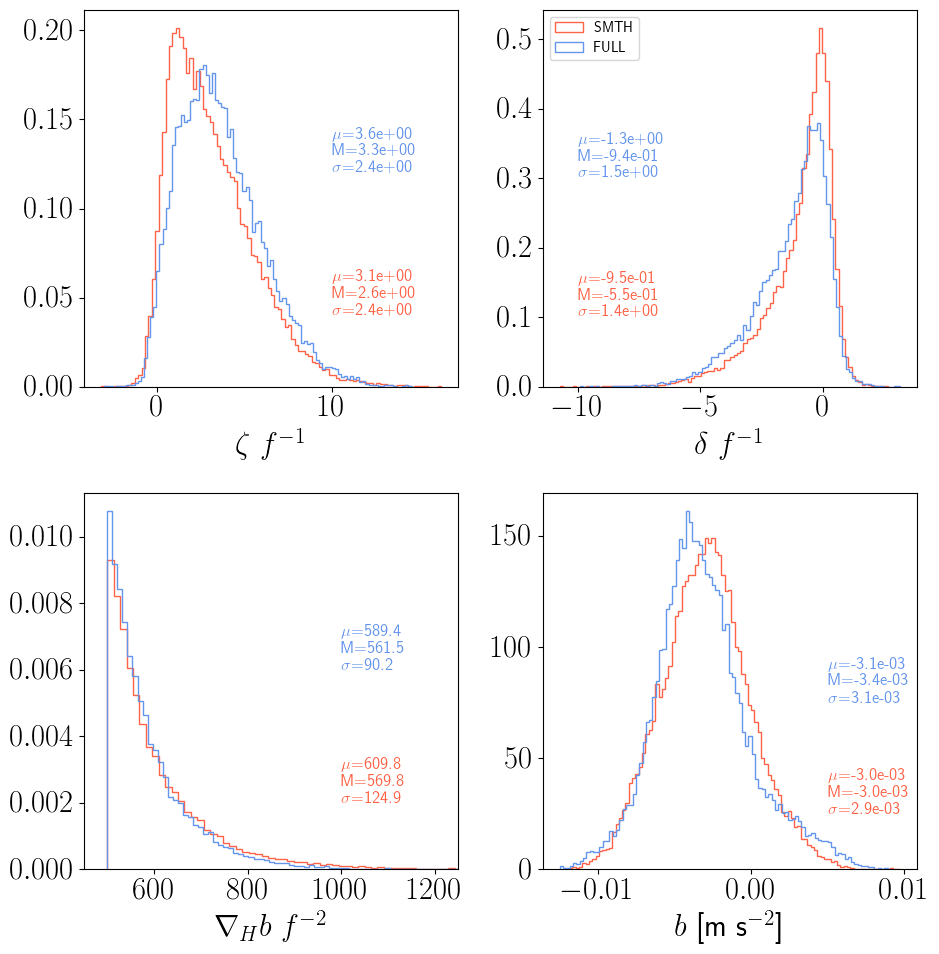

In [80]:
dbool=True
slog=False

a1=1
a2=1
lw=1
HT='step'

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(np.ravel((zeta_t/f)[mask_smth]),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel((zeta_f/f)[mask_full]),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)

# plt.text(3.1,0.4,r' $\mu$' + '={0:.1e} \n'.format(mean_f_z)+ r'M' + '={0:.1e} \n'.format(med_f_z) + r'$\sigma$'+'={0:.1e}'.format(std_f_z),color='cornflowerblue',fontsize=12)
# plt.text(3.1,0.2,r' $\mu$' + '={0:.1e} \n'.format(mean_t_z)+ r'M' + '={0:.1e} \n'.format(med_t_z) + r'$\sigma$'+'={0:.1e}'.format(std_t_z),color='tomato',fontsize=12) 
plt.text(10,0.12,r' $\mu$' + '={0:.1e} \n'.format(mean_f_z)+ r'M' + '={0:.1e} \n'.format(med_f_z) + r'$\sigma$'+'={0:.1e}'.format(std_f_z),color='cornflowerblue',fontsize=12)
plt.text(10,0.04,r' $\mu$' + '={0:.1e} \n'.format(mean_t_z)+ r'M' + '={0:.1e} \n'.format(med_t_z) + r'$\sigma$'+'={0:.1e}'.format(std_t_z),color='tomato',fontsize=12) 

# plt.xlim(-3,5)
plt.xlabel(r'$\zeta$ $f^{-1}$')


plt.subplot(2,2,2)
plt.hist(np.ravel((div_t/f)[mask_smth]),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,label='SMTH',density=dbool,log=slog)
plt.hist(np.ravel((div_f/f)[mask_full]),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,label='FULL',density=dbool,log=slog)
plt.legend(fontsize=10,loc=2)



plt.text(-10,0.3,r' $\mu$' + '={0:.1e} \n'.format(mean_f_div)+ r'M' + '={0:.1e} \n'.format(med_f_div) + r'$\sigma$'+'={0:.1e}'.format(std_f_div),color='cornflowerblue',fontsize=12)
plt.text(-10,0.1,r' $\mu$' + '={0:.1e} \n'.format(mean_t_div)+ r'M' + '={0:.1e} \n'.format(med_t_div) + r'$\sigma$'+'={0:.1e}'.format(std_t_div),color='tomato',fontsize=12) 
# plt.text(1.2,0.8,r' $\mu$' + '={0:.1e} \n'.format(mean_f_div)+ r'M' + '={0:.1e} \n'.format(med_f_div) + r'$\sigma$'+'={0:.1e}'.format(std_f_div),color='cornflowerblue',fontsize=12)
# plt.text(1.2,0.4,r' $\mu$' + '={0:.1e} \n'.format(mean_t_div)+ r'M' + '={0:.1e} \n'.format(med_t_div) + r'$\sigma$'+'={0:.1e}'.format(std_t_div),color='tomato',fontsize=12) 


# plt.xlim(-2.5,2.5)
plt.xlabel(r'$\delta$ $f^{-1}$')


plt.subplot(2,2,3)
plt.hist(np.ravel(bM_smth_norm[mask_smth]),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(bM_full_norm[mask_full]),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)

plt.text(1000,0.006,r' $\mu$' + '={0:.1f} \n'.format(mean_f_gb)+ r'M' + '={0:.1f} \n'.format(med_f_gb) + r'$\sigma$'+'={0:.1f}'.format(std_f_gb),color='cornflowerblue',fontsize=12)
plt.text(1000,0.002,r' $\mu$' + '={0:.1f} \n'.format(mean_t_gb)+ r'M' + '={0:.1f} \n'.format(med_t_gb) + r'$\sigma$'+'={0:.1f}'.format(std_t_gb),color='tomato',fontsize=12) 
# plt.text(200,0.016,r' $\mu$' + '={0:.1f} \n'.format(mean_f_gb)+ r'M' + '={0:.1f} \n'.format(med_f_gb) + r'$\sigma$'+'={0:.1f}'.format(std_f_gb),color='cornflowerblue',fontsize=12)
# plt.text(200,0.008,r' $\mu$' + '={0:.1f} \n'.format(mean_t_gb)+ r'M' + '={0:.1f} \n'.format(med_t_gb) + r'$\sigma$'+'={0:.1f}'.format(std_t_gb),color='tomato',fontsize=12) 


# plt.xlim(0,250)
plt.xlim(450,1250)
# plt.xlim(100,1250)




plt.xlabel(r'$\nabla_H b$ $f^{-2}$')


plt.subplot(2,2,4)
plt.hist(np.ravel(bt[:,1:-1,:].data[mask_smth]),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(bf[:,1:-1,:].data[mask_full]),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)


plt.text(0.005,75,r' $\mu$' + '={0:.1e} \n'.format(mean_f_b)+ r'M' + '={0:.1e} \n'.format(med_f_b) + r'$\sigma$'+'={0:.1e}'.format(std_f_b),color='cornflowerblue',fontsize=12)
plt.text(0.005,25,r' $\mu$' + '={0:.1e} \n'.format(mean_t_b)+ r'M' + '={0:.1e} \n'.format(med_t_b) + r'$\sigma$'+'={0:.1e}'.format(std_t_b),color='tomato',fontsize=12) 
# plt.text(0.01,50,r' $\mu$' + '={0:.1e} \n'.format(mean_f_b)+ r'M' + '={0:.1e} \n'.format(med_f_b) + r'$\sigma$'+'={0:.1e}'.format(std_f_b),color='cornflowerblue',fontsize=12)
# plt.text(0.01,25,r' $\mu$' + '={0:.1e} \n'.format(mean_t_b)+ r'M' + '={0:.1e} \n'.format(med_t_b) + r'$\sigma$'+'={0:.1e}'.format(std_t_b),color='tomato',fontsize=12) 



plt.xlabel(r'$b$ [m s$^{-2}$]')
# plt.xlim(-0.02,0.02)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_assessment_{0}f_buoyancy_log.png'.format(val_b))
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_assessment_high_buoyancy_log.png')



# MLD and PBL

In [81]:
hbl_f=varf['hbl'][:,120:-120,120:800].compute()
hbl_t=vart['hbl'][:,120:-120,120:800].compute()

In [82]:
hbl_high_full=hbl_f[:,1:-1,:].data[mask_full]
hbl_high_smth=hbl_t[:,1:-1,:].data[mask_smth]

In [83]:
mld_mean_full,mld_median_full,mld_std_full=np.nanmean(hbl_high_full),np.nanmedian(hbl_high_full),np.nanstd(hbl_high_full)
mld_mean_smth,mld_median_smth,mld_std_smth=np.nanmean(hbl_high_smth),np.nanmedian(hbl_high_smth),np.nanstd(hbl_high_smth)

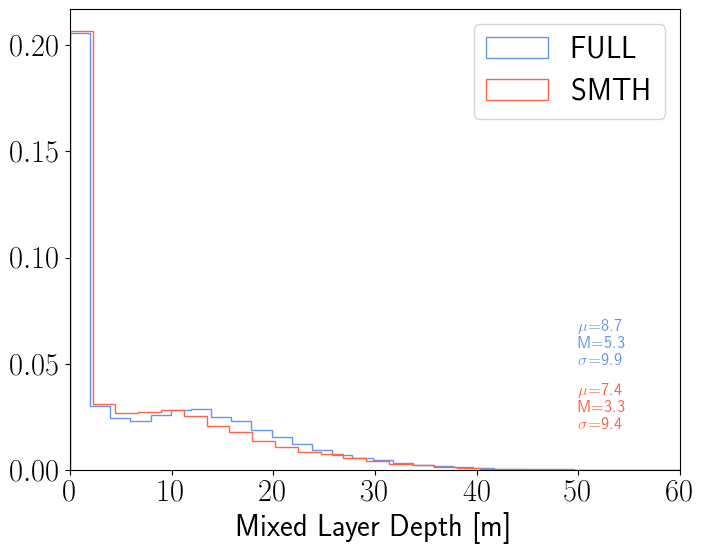

In [86]:

dbool=True
slog=False

a1=1
a2=1
lw=1
HT='step'


plt.figure(figsize=(7.5,6))
plt.hist(hbl_high_full,bins=50,color='cornflowerblue',label='FULL',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(hbl_high_smth,bins=50,color='tomato',label='SMTH',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)


plt.text(50,0.05,r' $\mu$' + '={0:.1f} \n'.format(mld_mean_full)+ r'M' + '={0:.1f} \n'.format(mld_median_full) + r'$\sigma$'+'={0:.1f}'.format(mld_std_full),color='cornflowerblue',fontsize=12)
plt.text(50,0.02,r' $\mu$' + '={0:.1f} \n'.format(mld_mean_smth)+ r'M' + '={0:.1f} \n'.format(mld_median_smth) + r'$\sigma$'+'={0:.1f}'.format(mld_std_smth),color='tomato',fontsize=12) 




plt.legend()
plt.xlabel('Mixed Layer Depth [m]')
# plt.grid()
plt.xlim(0,60)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_MLD_high_buoyancy_log.png')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_MLD_{0}f_buoyancy_log.png'.format(val_b))




## Joint Histograms

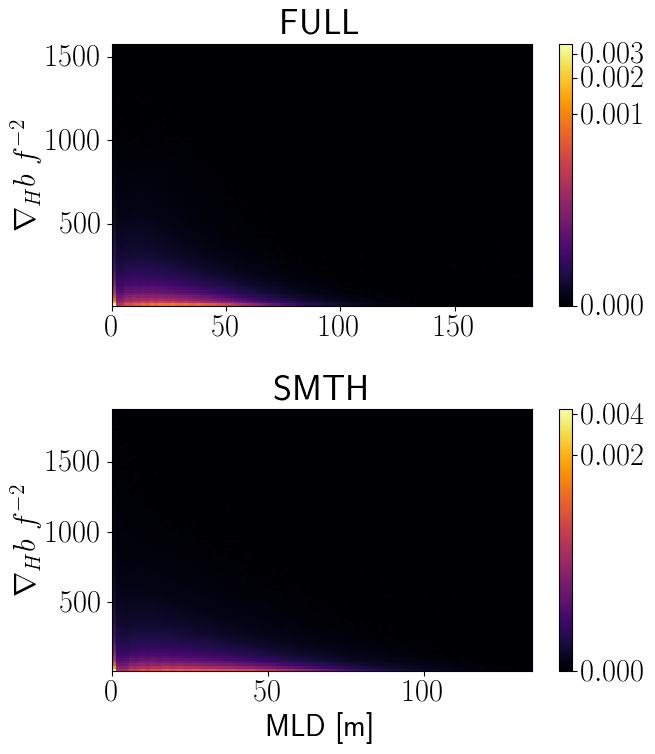

In [30]:
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
plt.hist2d(hbl_high_full,np.ravel(bM_full_norm[mask_full]),bins=100,density=True,norm=mcolors.PowerNorm(0.25),cmap='inferno')
plt.colorbar()
plt.ylabel(r'$\nabla_H b$ $f^{-2}$')
# plt.xlim(0,50)
# plt.ylim(500,1500)
plt.title('FULL')



plt.subplot(2,1,2)
plt.hist2d(hbl_high_smth,np.ravel(bM_smth_norm[mask_smth]),bins=100,density=True,norm=mcolors.PowerNorm(0.25),cmap='inferno')
plt.xlabel('MLD [m]')
plt.ylabel(r'$\nabla_H b$ $f^{-2}$')
# plt.xlim(0,50)
# plt.ylim(500,1500)
plt.colorbar()
plt.title('SMTH')

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/hist2D_MLDxgradB_high.png')

